# RL compatible environment design

RL algorithms require data in State, Action, Next State, Reward and done format for appropriate calulation of loss. 

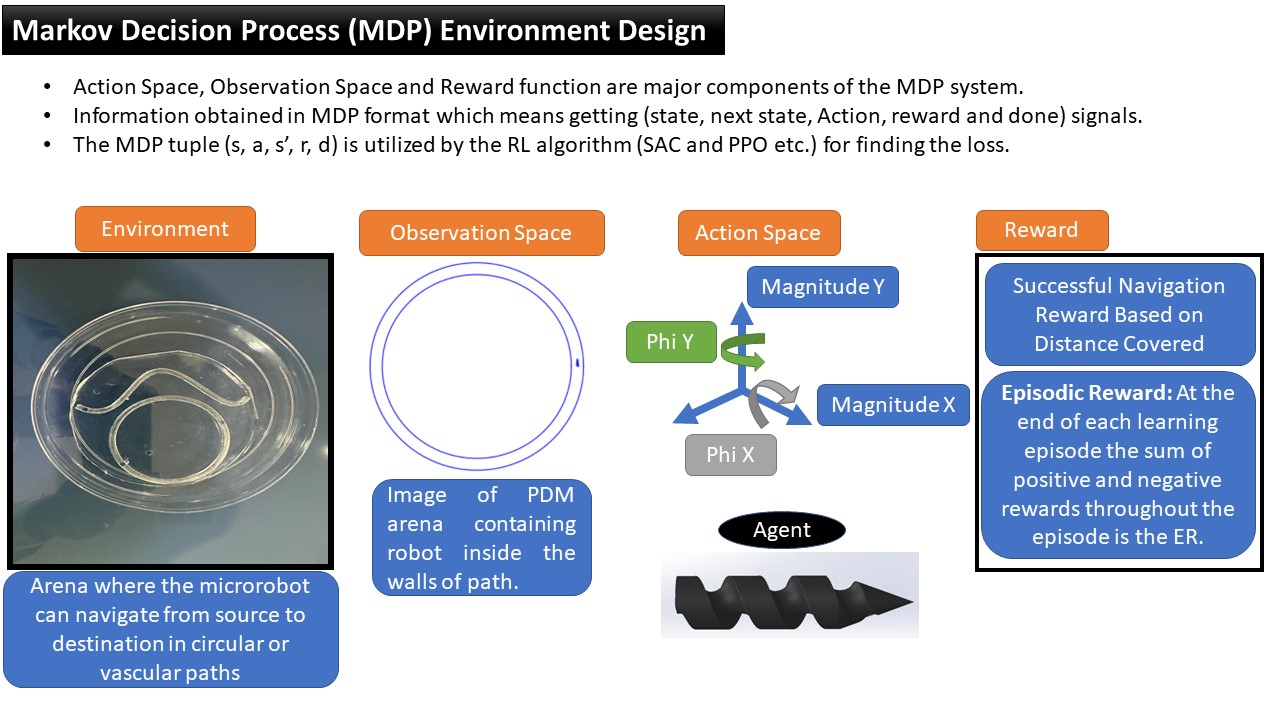

These are a random range of possible actions which are discretized from the action range and produced 625 discrete actions. 

In [1]:
"""
nn=5
act1=np.linspace(-1,1,nn)
act2=np.linspace(-1,1,nn)
act3=np.linspace(-np.pi,np.pi,nn)
act4=np.linspace(-np.pi,np.pi,nn)
action=np.ndarray((nn**4,4))
m=0
for i in range(0,nn):
  for j in range(0,nn):
    for k in range(0,nn):
      for l in range(0,nn):
        action[m,:]=np.array([act1[i],act2[j],act3[k],act4[l]])
        m=m+1
na=m
"""

'\nnn=5\nact1=np.linspace(-1,1,nn)\nact2=np.linspace(-1,1,nn)\nact3=np.linspace(-np.pi,np.pi,nn)\nact4=np.linspace(-np.pi,np.pi,nn)\naction=np.ndarray((nn**4,4))\nm=0\nfor i in range(0,nn):\n  for j in range(0,nn):\n    for k in range(0,nn):\n      for l in range(0,nn):\n        action[m,:]=np.array([act1[i],act2[j],act3[k],act4[l]])\n        m=m+1\nna=m\n'

# **Agent Design using MDP environment for Microrobot **

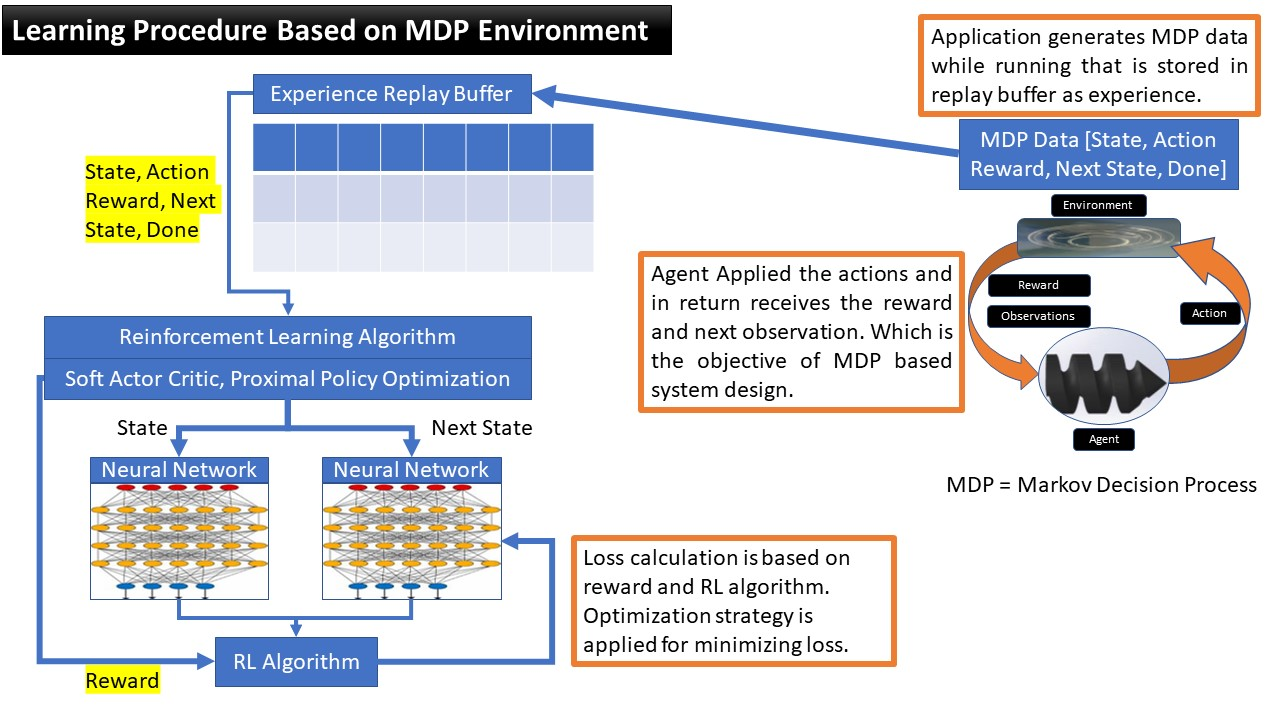

Hyperparameters that will be used in optimization statge.

In [2]:
# miscellaneous tools and library functions required for different computations, ploting and display management 
import numpy as np
from numpy.linalg import inv
import math
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import clear_output
from mpl_toolkits.axisartist.axislines import Subplot
# Libraries required for open AI gym compatible env design 
import gym
from gym import spaces
# Tensorflow layers and main API loading 
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp # Probability distribution function 


# Dqeqe required for replay buffer
from collections import deque


#from stable_baselines3.common.env_checker import check_env
import cv2
from google.colab.patches import cv2_imshow
#from pyvirtualdisplay import Display
#import moviepy.editor as mpy

# Display is not working for now, I am commenting it out for this time.
# create and start virtual display
#display = Display(backend='xvfb')
#display.start()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Design of Neural Network function approximator for implementing the brain of RL agent (It is required optmization and architecture changes which will be made in next week while optimizaion)

In [65]:
# Class that converts the current into its 6 components required in Mangetic Field Computations. 
class current:
  def __init__(self, Ix,Iy,Iz):
    self.I1=Ix
    self.I2=Iy
    self.I3=Iz
    self.I4=-Ix
    self.I5=-Iy
    self.I6=-Iz

  def Allcurrents(self):
    I=self
    return I
# Microrobot Model free environment which models the microrobot strcture, magnetic forces produced by varying current and magnetic fields, thrust force due to varying magnetic field.  
class mirobot_env(gym.Env):
  metadata = {"render.modes": ["human"]}
  def __init__(self):
    super(mirobot_env, self).__init__()
    self.action_space = spaces.Box(low = np.array([-100,-100,0,0]), high = np.array([100,100,2*np.pi,2*np.pi]), shape=(4,), dtype=np.float32)
    self.observation_space = spaces.Box(low = 0.0, high = 255.0, shape=(370,370,3), dtype=np.float32)
    self.th = 0.0
    self.St = 0
    self.x_M,self.y_M,self.z_M = None, None, None
    self.X_M,self.Y_M,self.Z_M = None, None, None
    self.ax = None
    self.f = 15
    self.t = 0
    self.m = 1
    self.nh = None
    self.P0 = None
    self.states=np.linspace(0,2*np.pi,100)
    self.epi_reward = 0
    self.rendering = False
    self.count = 0

  def system_reset(self): # overall reset function that resets all variables used for computations. 
    m=1  # microrobot magnetization
    n=50
    nh=4
    ths=np.array(np.linspace(0,4*2*np.pi,n))
    a=0.1*1e-3
    r=0.5*1e-3
    P0=self.spiralMicroRobot(a,r,ths)
    Rot=self.rotationmatrix(np.pi/2,0,0)
    P=np.matmul(Rot,P0.T)
    #ax = plt.figure().add_subplot(projection='3d')

    # syntax for 3-D projection#ax = plt.axes(projection ='3d')
    # ax.set_title('3D line plot geeks for geeks')
    # plt.show()

    

    f=15.9#Frequency f Fixed 15.9 Hz (ω=2*180*f=20 rad/s)
    #Mx=[-1,1];%Magnitude X MX RL agent [-1,1] unitless
    # My=[-1,1];%Magnitude Z MZ max(|MX|,|MY|) [0,1] unitless
    # Mz=[0,1];%Magnitude Z MZ max(|MX|,|MY|) [0,1] unitless
    # Phix=[0,2*pi];%Phase Angle X φX RL agent [0,2π] radians
    # Phiy=[0,2*pi];%Phase Angle Y φY RL agent [0,2π] radians
    n=1
    rr=40*1e-3
    x_M = np.linspace(-rr,rr,n)# x (cm)
    y_M = np.linspace(-rr,rr,n)# y (cm)
    z_M = np.linspace(-rr,rr,n)# z (cm)
    [X_M,Y_M,Z_M]=np.meshgrid(x_M,y_M,z_M)


    # plt.zlim([-1.5*rr, 1.5*rr])
    ix=[]
    iy=[]
    iz=[]

    phix=[]
    phiy=[]
    Thx=[]
    Thy=[]
    Thz=[]
    thc = np.linspace(0,2*np.pi)
    th=np.pi/4
    # t=np.linspace(0,10,100)
    dt=1/f
    t=0
    St=0

    return St, t, dt, th, thc,Thz, Thy, Thx, phix, phiy, ix, iy,iz,[X_M,Y_M,Z_M], x_M,y_M,z_M, rr,f,P,Rot,P0,r,a,ths, nh,m

  def spiralMicroRobot(self,a,r,ths): # Function computes the coordinates for the shape of robot
      shape=np.ndarray((len(ths),3))
      for i in range(0,len(ths)):
        if i<2*len(ths)/3:
          r=0.99*r
        else:
          r=0.95*r
        shape[i,:]=np.array([a*ths[i],r*np.cos(ths[i]),r*np.sin(ths[i])])# # shape of microrobot
      return shape
  def rotationmatrix(self, thx,thy,thz): # Find the impact of X, Y, Z thrust forces on the rotation of robot. 
      Rotx=np.array([[1, 0, 0],[0 ,np.cos(thx), -np.sin(thx)],[0 ,np.sin(thx), np.cos(thx)]])
      Roty=np.array([[np.cos(thy) ,0 ,np.sin(thy)],[0 ,1 ,0],[-np.sin(thy), 0, np.cos(thy)]])
      Rotz=np.array([[np.cos(thz) ,-np.sin(thz), 0],[np.sin(thz), np.cos(thz) ,0],[0, 0, 1]])
      Rot=np.matmul(Rotx,Roty,Rotz)
      return Rot
  
  def magnetField(self,I,X,Y,Z):  # We take the current and the coordinates of the region where magnetic field will be produced
      n=20
      N=50
      nw=400
      # Source points (where there is a current source)
      th =np.array( np.linspace(-N*2*np.pi,N*2*np.pi,nw))
      Gammax =np.array([th.T/n,np.cos(th.T),np.sin(th.T)])# x,y,z (cm,cm,cm)
      Gammay = np.array([np.cos(th.T),th.T/n,np.sin(th.T)])# x,y,z (cm,cm,cm)
      Gammaz = np.array([np.cos(th.T),np.sin(th.T),th.T/n])# x,y,z (cm,cm,cm)
      l=33*1e-3

      Gammax1 = numpy.matlib.repmat([l, 0, 0],len(th),1)+Gammax.T#-pi/4 about x axis\
      Gammay1 = numpy.matlib.repmat([0 ,l ,0],len(th),1)+Gammay.T#pi/6 about y axis
      Gammaz1 = numpy.matlib.repmat([0 ,0, l],len(th),1)+Gammaz.T #pi/6 about z axis
      Gammax2 = numpy.matlib.repmat([-l ,0, 0],len(th),1)+Gammax.T#pi/4 about x axis\
      Gammay2 = numpy.matlib.repmat([0 ,-l, 0],len(th),1)+Gammay.T#pi/6 about y axis
      Gammaz2 = numpy.matlib.repmat([0, 0 ,-l],len(th),1)+Gammaz.T #pi/6 about z axis

      I1 = I.I1# solenoid 1 current (A)
      I2 = I.I2#solenoid 2 current (A)
      I3 = I.I3#solenoid 2 current (A)
      I4 = I.I4# solenoid 1 current (A)
      I5 = I.I5#solenoid 2 current (A)
      I6 = I.I6#solenoid 2 current (A)

      dGamma = 1 # filament max discretization step [m]
      nf = 6
      # Initialize the space without any charge 
      BX = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      BY = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      BZ = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      dBX = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      dBY = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      dBZ = np.zeros((X.shape[0],X.shape[1],X.shape[2]))

      # find current distribution 
      for i in range(0,nf):
        if i==0:
          Gamma=Gammax1
          I=I1
        elif i==1:
          Gamma=Gammay1
          I=I2
        elif i==2:
          Gamma=Gammaz1
          I=I3
        elif i==3:
          Gamma=Gammax2
          I=I4
        elif i==4:
          Gamma=Gammay2
          I=I5
        elif i==5:
          Gamma=Gammaz2
          I=I6

        [BX,BY,BZ,dBX,dBY,dBZ]=self.BSmag_get_B(nw,nf,Gamma,dGamma,I,self.X_M,self.Y_M,self.Z_M,BX,BY,BZ)
      return X,Y,Z,BX,BY,BZ,dBX,dBY,dBZ
  def BSmag_get_B(self,nw,nf,Gamma,dGamma,I,X,Y,Z,BX,BY,BZ):  
      # Takes in the magnetic field space and current distribution in the area for finding magnetic filed present in the area.
      mu0 = 4*np.pi*1e-7    # vacuum permeability [N/A^2]
          

          # Discretization of Gamma
      x_P = []
      y_P = []
      z_P = []
      N = Gamma.shape[0]-1  # Number of points defining Gamma
      for i in range(0,N):
        L_Gamma_i = np.linalg.norm(Gamma[i,:]-Gamma[i+1,:])

        NP = np.ceil(L_Gamma_i/dGamma).astype(int)  # Number of points required to have a discretization step smaller than dGamma

        x_P=np.append(x_P,np.array(np.linspace(Gamma[i,0], Gamma[i+1,0], NP))) # discretization of Gamma for x component
        y_P=np.append(y_P,np.array(np.linspace(Gamma[i,1], Gamma[i+1,1], NP)))  # discretization of Gamma for y component
        z_P=np.append(z_P,np.array(np.linspace(Gamma[i,2], Gamma[i+1,2], NP)))  # discretization of Gamma for z component

      
      dBX = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      dBY = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      dBZ = np.zeros((X.shape[0],X.shape[1],X.shape[2]))
      # Add contribution of each source point P on each field point M (where we want to calculate the field)
      for m in range(0,X.shape[0]):
        for n in range(0,X.shape[1]):
          for p in range(0,X.shape[2]):
            # M is the field point
            x_M = X[m,n,p]
            y_M = Y[m,n,p]
            z_M = Z[m,n,p]

             # Loop on each discretized segment of Gamma PkPk+1

            [dBX0,dBY0,dBZ0]=self.magnetGradient(x_M, y_M,z_M,x_P,y_P,z_P,nw,mu0,I)
            dBX[m,n,p]=dBX0
            dBY[m,n,p]=dBY0
            dBZ[m,n,p]=dBZ0
            BX[m,n,p] = BX[m,n,p] + dBX[m,n,p]
            BY[m,n,p] = BY[m,n,p] + dBY[m,n,p] 
            BZ[m,n,p] = BZ[m,n,p] + dBZ[m,n,p]
            normB=np.sqrt(BX**2+BY**2+BZ**2)
            #ax.quiver(X[,:,0], Y[:,:,0], Z[:,:,0],BX[:,:,0]/normB[:,:,0], BY[:,:,0]/normB[:,:,0],BZ[:,:,0]/normB[:,:,0],color='g',alpha=1,length=0.01)  

      return BX,BY,BZ,dBX,dBY,dBZ
  def magnetGradient(self,x, y,z,x_P,y_P,z_P,nw,mu0,I) : 
    # Calculates the changes in magnetic field happening due to 
    # change in current. 

      DBx=np.zeros((len(x_P)-1,1))
      DBy=np.zeros((len(x_P)-1,1))
      DBz=np.zeros((len(x_P)-1,1))
      for k in range( 0,len(x_P)-1):
        P = (np.sqrt((x-x_P[k])**2 + (y-y_P[k])**2 + (z-z_P[k])**2))**3
        DBx[k] = ((y_P[k+1]-y_P[k])*(z-z_P[k])-(z_P[k+1]-z_P[k])*(y-y_P[k]))/P
        DBy[k] = ((z_P[k+1]-z_P[k])*(x-x_P[k])-(x_P[k+1]-x_P[k])*(z-z_P[k]))/P
        DBz[k] = ((x_P[k+1]-x_P[k])*(y-y_P[k])-(y_P[k+1]-y_P[k])*(x-x_P[k]))/P

      dBX = nw*mu0*I/4/np.pi*np.sum(DBx)
      dBY = nw*mu0*I/4/np.pi*np.sum(DBy)
      dBZ = nw*mu0*I/4/np.pi*np.sum(DBz)

      return dBX,dBY,dBZ
  
  def helicalMatrix(self,n,R,eta,a): # It is a constant representing the shape of robot under the impact of magnetic fields. 
    th=np.pi/4
    em=4*np.pi*eta/(np.log(0.36*np.pi*R/(a*np.sin(th)))+0.5)
    en=2*np.pi*eta/np.log(0.36*np.pi*R/(a*np.sin(th)))
    A=2*np.pi*n*R*(em*np.cos(th)**2+en*np.sin(th)**2)/np.sin(th)
    B=2*np.pi*n*(R**2)*(em-en)*np.cos(th)
    D=2*np.pi*n*(R**3)*(en*np.cos(th)**2+em*np.sin(th)**2)/np.sin(th)
    H=np.array([[A,B],[B,D]])
    return H
  def get_state(self,St): 
    # this functions takes the state of the microrobot from the matplotlib grapgh and
    # converts it into png image. It crops the additional regions and return only the regions of interest.  
    th=self.states[St] 
    r=33*1e-3
    Pr=[r*np.cos(th),r*np.sin(th),0]
    rr=40*1e-3
    r1 = 35*1e-3;xc1 = 0;yc1 = 0
    angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
    xs = np.cos(angles)
    ys = np.sin(angles)
    #clear_output()
    plot = plt.figure(figsize =(8, 8))

    plt.xlim([-1.1*rr, 1.1*rr])
    plt.ylim([-1.1*rr, 1.1*rr])
    plt.plot(r1*xs, r1*ys, color = 'b')

    r2 = 31*1e-3
    xc2 = 0
    yc2 = 0
    plt.plot(r2*xs, r2*ys, color = 'b')
    n=50
    nh=4
    ths=np.array(np.linspace(0,4*2*np.pi,n))
    a=0.1*1e-3
    r=0.5*1e-3
    P0=self.spiralMicroRobot(a,r,ths)
    Rot=self.rotationmatrix(th+np.pi/2,th+np.pi/2,0)
    Prot=np.matmul(Rot,P0.T)
    Rh=0.1*1e-3
    etah=4*1e-3
    ah=0.05*1e-3
    H=self.helicalMatrix(nh,Rh,etah,ah)
    P=numpy.matlib.repmat(Pr,Prot.shape[1],1)+Prot.T # microrbot new position
    plt.plot(P[:,0],P[:,1],'r')

    plt.savefig('saved_figure.png')

    imageread = cv2.imread('/content/saved_figure.png')
    #displaying the image as the output on the screen
    cropped_image = imageread[100:470, 110:480]
    if self.rendering == False:
      plt.close()
      return cropped_image
    else:
      return cropped_image
  def render(self, mode="human"):
    th=self.states[self.St] 
    r=33*1e-3
    Pr=[r*np.cos(th),r*np.sin(th),0]
    rr=40*1e-3
    r1 = 35*1e-3;xc1 = 0;yc1 = 0
    angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
    xs = np.cos(angles)
    ys = np.sin(angles)
    #clear_output()
    plot = plt.figure(figsize =(8, 8))

    plt.xlim([-1.1*rr, 1.1*rr])
    plt.ylim([-1.1*rr, 1.1*rr])
    plt.plot(r1*xs, r1*ys, color = 'b')

    r2 = 31*1e-3
    xc2 = 0
    yc2 = 0
    plt.plot(r2*xs, r2*ys, color = 'b')
    n=50
    nh=4
    ths=np.array(np.linspace(0,4*2*np.pi,n))
    a=0.1*1e-3
    r=0.5*1e-3
    P0=self.spiralMicroRobot(a,r,ths)
    Rot=self.rotationmatrix(th+np.pi/2,th+np.pi/2,0)
    Prot=np.matmul(Rot,P0.T)
    Rh=0.1*1e-3
    etah=4*1e-3
    ah=0.05*1e-3
    H=self.helicalMatrix(nh,Rh,etah,ah)
    P=numpy.matlib.repmat(Pr,Prot.shape[1],1)+Prot.T # microrbot new position
    plt.plot(P[:,0],P[:,1],'r')
    plt.pause(0.00000001)
  def close (self):
        pass
  def reset(self): # It is a reset function that will be called at the end of every episode to re-initialize all the variables. 
    self.St, self.t, self.dt, th, thc,Thz, Thy, Thx, phix, phiy, ix, iy,iz,[self.X_M,self.Y_M,self.Z_M], self.x_M,self.y_M,self.z_M, rr,self.f,P,Rot,self.P0,r,a,ths, self.nh,self.m = self.system_reset()
    image_state = self.get_state(self.St)
    self.epi_reward = 0
    #image_state = cv2.resize(image_state, (28, 28))
    #image_state = cv2.cvtColor(image_state, cv2.COLOR_BGR2RGB)
    self.count = 0

   
    return image_state
  def step(self, action):
    reward = 0 
    done = False 
    r=33*1e-3
    self.th = self.states[self.St] # Current state of the microrobot
    Pr=[r*np.cos(self.th),r*np.sin(self.th),0] # Regions under the influence of magnetic field. 

    # Three component of each coordinates for the magnetic field. 
    ii=np.argmin((self.x_M-Pr[0])**2)
    jj=np.argmin((self.y_M-Pr[1])**2)
    kk=np.argmin((self.z_M-Pr[2])**2)
    # Reading actions value from the agent actions 
    Mx=action[0]
    My=action[1]
    Mz= np.max((np.abs(Mx),np.abs(My)))
    Phix=action[2]
    Phiy=action[3]
    # Finding the currents in the coil based on actions. 
    thx=self.f*self.t + Phix
    thy=self.f*self.t + Phiy
    thz=self.f*self.t
    Ix = Mx*np.sin(thx)#Current in X-axis coil I
    Iy = My*np.sin(thy)#Current in Y-axis coil I
    Iz = Mz*np.sin(thz)#Current in Z-axis coil I
    resultant_currents = [Ix, Iy, Iz]
    Cu=current(Ix,Iy,Iz)
    I=Cu.Allcurrents() 
    # Finding the change in magnetic field due to changes in current  
    [X,Y,Z,BX,BY,BZ,dBX,dBY,dBZ]=self.magnetField(I,self.X_M,self.Y_M,self.Z_M)
    #normB=np.sqrt(BX**2+BY**2+BZ**2)

    # Present magnetization status of the microrobot due to the present angle of the microrobot 
    M=[0,self.m*np.cos(self.th+np.pi/2) ,self.m*np.sin(self.th+np.pi/2)]  #Microrobot magnetization  # Swimmer directon controller 
    # Calculates the strength of magnetic field in space 
    B=[BX[ii,jj,kk],BY[ii,jj,kk],BZ[ii,jj,kk]] # Controlling the speed of the microswimmer. 
    # Calculated Rate of change in magneti gradients which have impact on the speed of microrobot.
    dB=[[dBX[ii,jj,kk] , 0,0],[0,dBY[ii,jj,kk],0],[0,0,dBZ[ii,jj,kk]]]  

    # Calculations of force and torque based on the present magnetization status and current magnetic field strength 
    tow=np.cross(M, B)# torque implemented on the microrbot by the magnetic filed
    F=np.dot(M,dB)# force implemented by magnetic field gradients on the microrobot
    #print(F, tow, M)
    Rot=self.rotationmatrix(self.th+np.pi/2,self.th+np.pi/2,0)
    Prot=np.matmul(Rot,self.P0.T)
    Rh=0.1*1e-3
    etah=4*1e-3
    ah=0.05*1e-3
    H=self.helicalMatrix(self.nh,Rh,etah,ah) #  
    P=numpy.matlib.repmat(Pr,Prot.shape[1],1)+Prot.T
    # Movement of the microrobot under the influence of torque and force (due to magnetic field)
    N=np.matmul(inv(H),[F[0],tow[0]])
    v=N[0]# micorobot translational velocity after implementing force and torque
    dth=N[1]# micorobot angular velocity after implementing force and torque
    L=v*self.dt# movment of microrobot
    

    self.t=self.t+self.dt # Advancing time 
    
    delth=math.atan2(L,r) # angle of the movement claculated by "cos law"
    self.th=self.th+np.sign(v)*delth # the new angle of microrobot is the new satae
    #print("DT", self.dt, L, self.t, v, delth, self.th)

    # Now I will proceed to next state calculations.
    current_state=self.St
    self.St=np.argmin((self.states-self.th)**2)
    
    next_state=self.St
    self.th=self.states[self.St]
    #print(self.St, self.th)
    # Policy Selection 
    """
    # This reward strcture considers the reward for +20 degree movement however seems in appropriate 
    reward = 0
    policy = 20 # degree positive translation 
    current_translation = (delth*180)/np.pi
    #print(current_translation)
    
    if current_translation < 0:
      # negative translation the robot direction is wrong 
        reward += current_translation
    if (current_translation > policy - 1) and (current_translation < policy + 1):
        reward += policy # Policy encourging reward 
    if (current_translation >= policy + 1):
        reward += policy -   current_translation # Discouragement for not following the policy 
    if (current_translation >= 0) and (current_translation <= policy - 1):
      reward +=  current_translation
    """
    # This takes the translation only does not matter positive or negative. 
    # If the translation is less than equall to 20 degree the reward will be positive. 
    reward =-np.abs(delth-20)+20
    
    #print((delth*180), reward)
    #print(current_translation, reward)
    image_next = self.get_state(next_state)

    #self.epi_reward += reward
    
    
    if self.t > 5 or self.St==99: # or self.count > 200:
      done=True
      #reward += 100
      reward += self.epi_reward
    
    # Tracking some variables for monitoring the system later. 
    info = dict()
    info["P"] = P
    info['delth'] = delth # may be we can say that if the angle is 20 degree that mean +20 and -20 degree are considered as policy (without considering the direction of microrobot it self.) 
    # The delth can be used for controlling the robot objective, how swift or slow we want to move the robot. 
    # For this purpose in any given state if the change in displacement lies within the required range we give positive reward otherwise negative reward. 

    # To make it roboust to policies of different angle variations. We can chose random policies every time. It might take more time to learn.  
    info["force"]  = F
    info["torque"]  = tow
    info["momentum"] = M
    info['th_current'] = self.th
    info['th_previous'] = self.states[current_state]
    info['res_currents'] = resultant_currents
    info['time_elasped'] = self.t

    #image_next = cv2.resize(image_next, (28, 28))
    #image_next = cv2.cvtColor(image_next, cv2.COLOR_BGR2RGB)
    self.count += 1
    #print(delth)
    #print("DT2", self.th, self.St)
    return image_next, reward, done, info
    


# **Environment testing Section**

# **Agnet Defination **

Replay Buffer , Value, target value, soft q 1 , soft q 2 , policy network

In [53]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self):
    self.buffer = deque(maxlen=10000)

  def add(self, state, action, reward, next_state, done): # saves the information in buffer
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples): # takes a random sample which is equal to batch size. 
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions)
    rewards = np.array(rewards, dtype=np.float32)
    next_states = np.array(next_states, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)
    return states, actions, rewards, next_states, dones


# Defination of the value network 
class value_network(tf.keras.Model):
  def __init__(self):
    super(value_network, self).__init__()
    self.in_layer_image = layers.Conv2D(32, (3, 3), activation='relu',input_shape=(370, 370, 3), name='input_layer' )
    self.pool = layers.MaxPool2D()
    self.layer_1_image = layers.Conv2D(64, (3, 3), activation='relu')
    
    self.layer_2_image = layers.Conv2D(32, (3, 3), activation='relu')
    self.flatten = layers.Flatten()
    self.fully_connected1 = layers.Dense(32, activation='relu')
    #self.fully_connected2 = layers.Dense(32, activation='relu')
    #self.fully_connected3 = layers.Dense(32, activation='relu')
    self.value = layers.Dense(1, activation='linear', name='mu_out')

  def call(self, x):
    x = self.in_layer_image(x)
    x = self.pool(x)
    x = self.layer_1_image(x)
    x = self.pool(x)
    x = self.layer_2_image(x)
    x = self.flatten(x)
    x = self.fully_connected1(x)
    #x = self.fully_connected2(x)
    #x = self.fully_connected3(x)
    model_output = self.value(x)
    return model_output
# Defination of the soft Q network which maps the value based on state action pair. 
class soft_q_net(tf.keras.Model):
  def __init__(self):
    super(soft_q_net, self).__init__()
    self.in_layer_image = layers.Conv2D(32, (3, 3), activation='relu',input_shape=(370, 370, 3), name='input_layer' )
    self.pool = layers.MaxPool2D()
    self.layer_1_image = layers.Conv2D(64, (3, 3), activation='relu')
    
    self.layer_2_image = layers.Conv2D(32, (3, 3), activation='relu')
    self.flatten = layers.Flatten()
    self.fully_connected1 = layers.Dense(32, activation='relu')
    self.action_process = layers.Dense(32,input_shape=(4,), activation='relu')
    #self.fully_connected2 = layers.Dense(32, activation='relu')
    #self.fully_connected3 = layers.Dense(32, activation='relu')
    self.value = layers.Dense(1, activation='linear', name='value_out')

  def call(self, x,y):
    x = self.in_layer_image(x)
    x = self.pool(x)
    x = self.layer_1_image(x)
    x = self.pool(x)
    x = self.layer_2_image(x)
    img  = self.flatten(x)
    act = self.action_process(y)
    x = layers.concatenate([img, act])
    x = self.fully_connected1(x)
    #x = self.fully_connected2(x)
    #x = self.fully_connected3(x)
    model_output = self.value(x)
    return model_output
# Policy network for determining the action which are obtained by using the mu and sigma distribution obtained from the NN linear layer. 
class policy_network(tf.keras.Model):
  def __init__(self, num_actions):
    super(policy_network, self).__init__()
    self.in_layer_image = layers.Conv2D(32, (3, 3), activation='relu',input_shape=(370, 370, 3), name='input_layer' )
    self.pool = layers.MaxPool2D()
    self.layer_1_image = layers.Conv2D(16, (3, 3), activation='relu')
    self.pool = layers.MaxPool2D()
    self.layer_2_image = layers.Conv2D(32, (3, 3), activation='relu')
    self.flatten = layers.Flatten()
    #self.action_process = layers.Dense(4, activation='relu')
    self.fully_connected1 = layers.Dense(32, activation='relu')
    #self.fully_connected2 = layers.Dense(32, activation='relu')
    #self.fully_connected3 = layers.Dense(32, activation='relu')
    
    self.mu = layers.Dense(num_actions, activation='linear', name='mu_out')
    self.sigma = layers.Dense(num_actions, activation='linear', name="sigma_out")

  
  def evaluate(self,state, reparameterize=True, noise=1e-4 ):
    
    mu, sigma = self.call(state)
    sigma = tf.math.exp(sigma)
    dist = tfp.distributions.Normal(mu, sigma)
    #dist1 = tfp.distributions.Normal(0, 1)
    
    z    = dist.sample()
    #print(z)
    action = tf.keras.activations.tanh(mu+(sigma*z))
    #print(action) 
    log_prob = dist.log_prob(action)
    log_prob -= tf.math.log(1 - tf.math.pow(action, 2) + noise)
    log_prob = tf.math.reduce_sum(log_prob, axis=1, keepdims=True)
    """
    mean, log_std = self.call(state)
    log_std = np.exp(log_std)
    dist = tfp.distributions.Normal(0, 1)
    z = dist.sample()
    #print(mean, log_std)
    action = tf.keras.activations.tanh((mean*z)+log_std)
    log_prob = tfp.distributions.Normal(mean, log_std).log_prob(mean+ log_std*z) - tf.math.log(1 - tf.math.pow(action, 2) + 1e-2) 
    """
    return action, log_prob
  def call(self, x):
    x = self.in_layer_image(x)
    x = self.pool(x)
    x = self.layer_1_image(x)
    x = self.pool(x)
    x = self.layer_2_image(x)
    x = self.flatten(x)
    #x = self.action_process(x)
    x = self.fully_connected1(x)
    #x = self.fully_connected2(x)
    #x = self.fully_connected3(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    sigma = tf.clip_by_value(sigma, clip_value_min = -1, clip_value_max=1) # The value is approaching to zero. (0~,1) 
    return mu, sigma

  def get_action(self, state):
    action, log_prob = self.evaluate(state)
    print(action)
    action = action[0]
    Mx = action[0]*100
    My = action[1]*100
    phix = action[2]*np.pi*2
    phiy = action[3]*np.pi*2
    return [Mx.numpy(), My.numpy(), phix.numpy(), phiy.numpy()]



## SAC implementation for forward and backward propagation 

## Main_Code Training loop

## Testing the learned weights to check the working 

In [54]:
# Initializing the env and policy network for testing the environment. Further the learned weights are loaded to the neural network. 
env = mirobot_env()
policy_net = policy_network(num_actions = env.action_space.shape[0])
policy_net.build(input_shape=(None, 370, 370, 3))
policy_net.load_weights("/content/drive/MyDrive/Microrobot_Policy_Weights_40.h5")

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Angle Moved in Current Step:  18.30297668291704
Reward Earned in Current Step:  0.31944720603265253


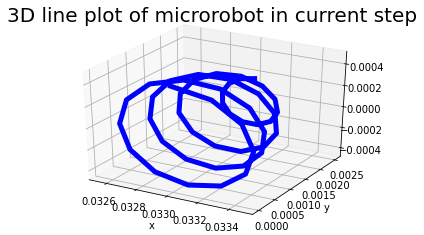

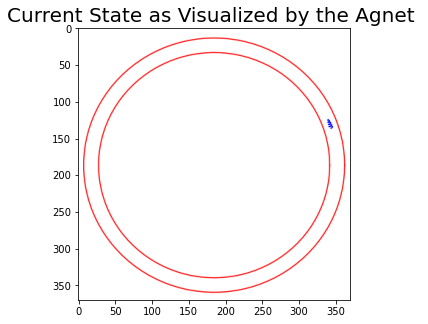

Angle Moved in Current Step:  52.3723900835355
Reward Earned in Current Step:  0.9140706440965225


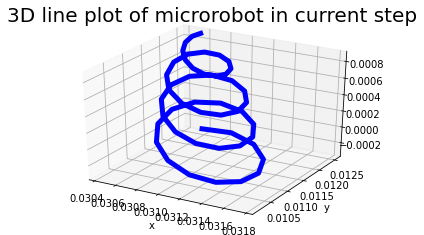

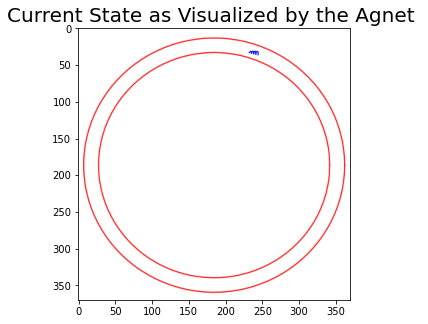

Angle Moved in Current Step:  2.681427264619203
Reward Earned in Current Step:  0.04679973442035035


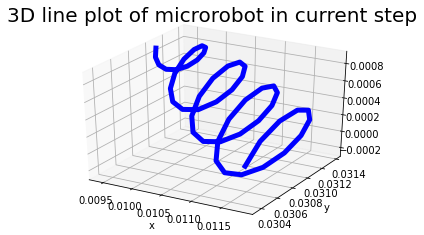

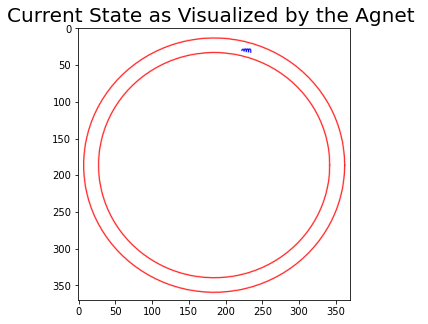

Angle Moved in Current Step:  41.298496618751045
Reward Earned in Current Step:  0.7207947421209511


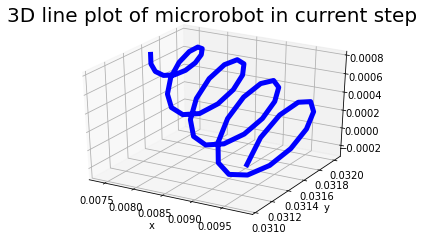

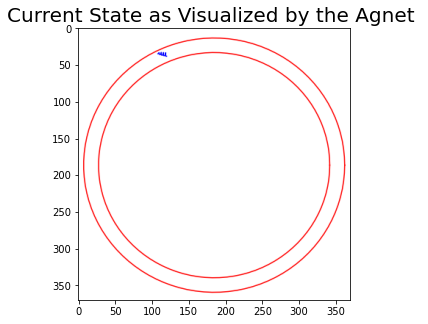

Angle Moved in Current Step:  17.657424091612608
Reward Earned in Current Step:  0.3081801878196089


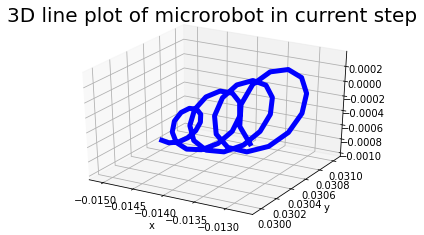

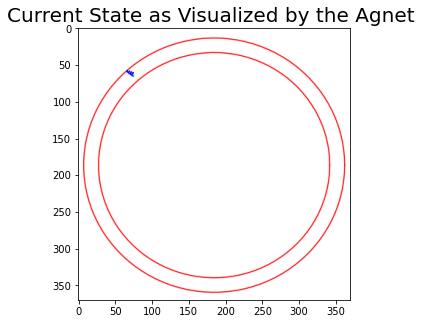

Angle Moved in Current Step:  50.590399058248664
Reward Earned in Current Step:  0.8829690334642777


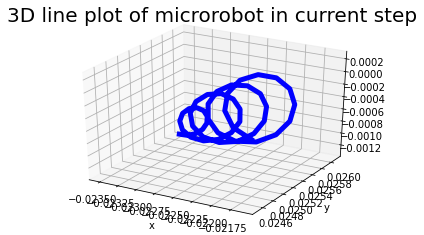

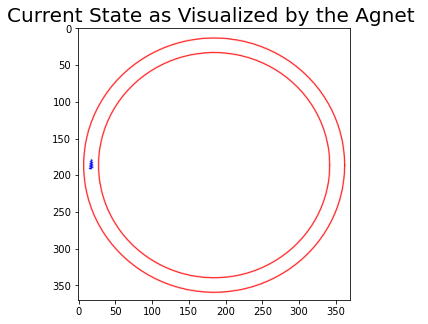

Angle Moved in Current Step:  5.411838106380252
Reward Earned in Current Step:  0.09445439354123053


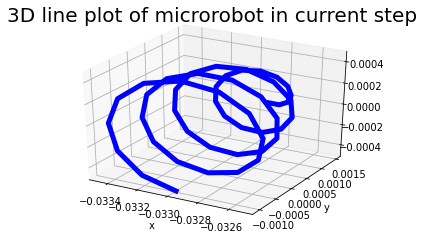

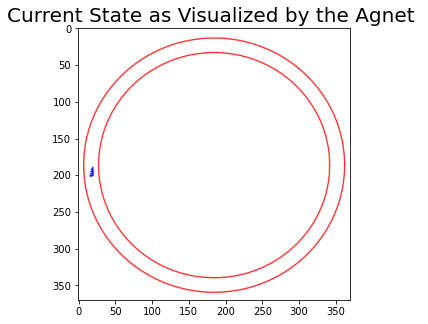

Angle Moved in Current Step:  -26.863947676532497
Reward Earned in Current Step:  -0.4688643370389727


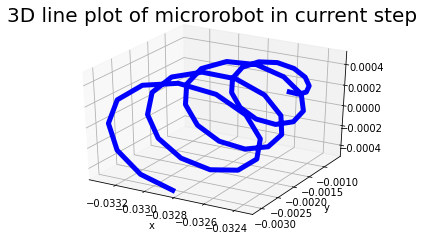

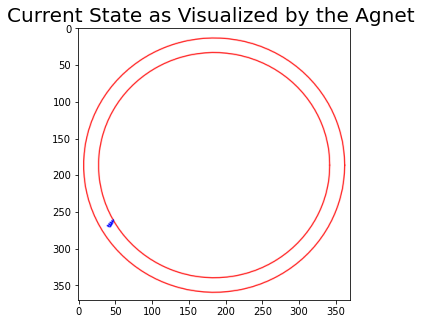

Angle Moved in Current Step:  -12.896286879124583
Reward Earned in Current Step:  -0.22508266732246796


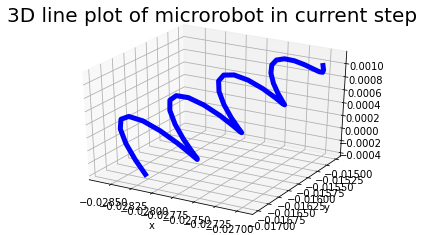

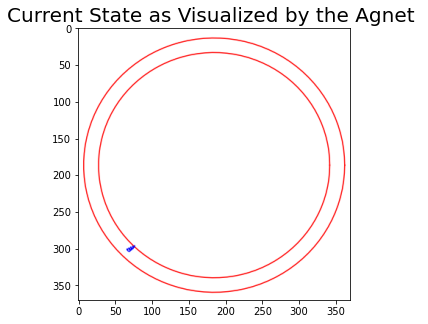

Angle Moved in Current Step:  2.317316594482138
Reward Earned in Current Step:  0.04044480438481557


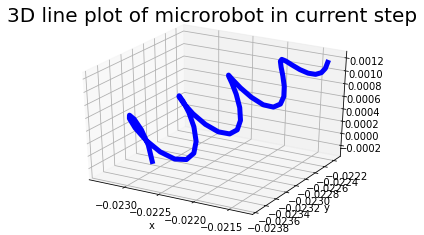

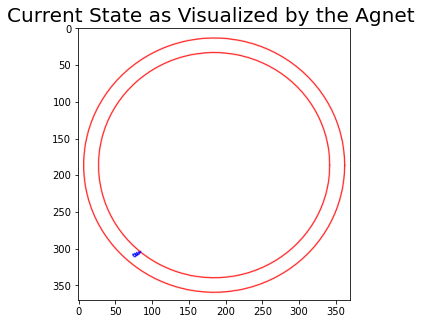

Angle Moved in Current Step:  26.95920904075431
Reward Earned in Current Step:  0.47052696149458484


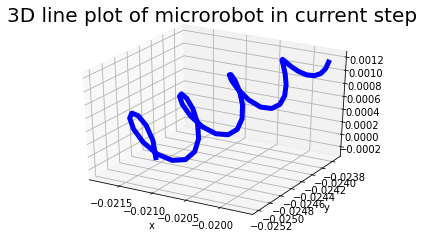

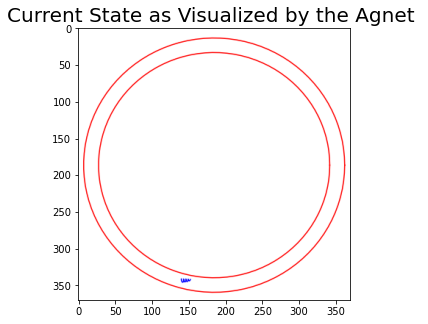

Angle Moved in Current Step:  -45.17364546560524
Reward Earned in Current Step:  -0.7884288485034183


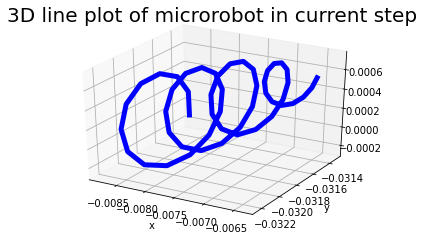

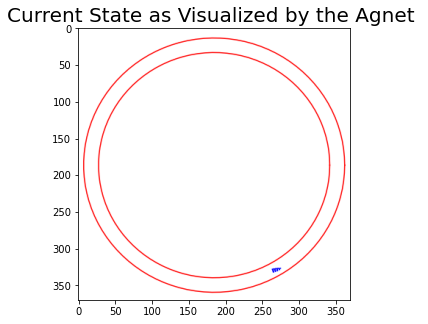

Angle Moved in Current Step:  -10.487489565849103
Reward Earned in Current Step:  -0.1830412231926175


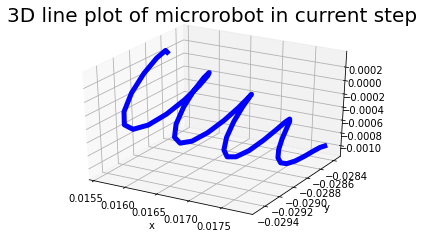

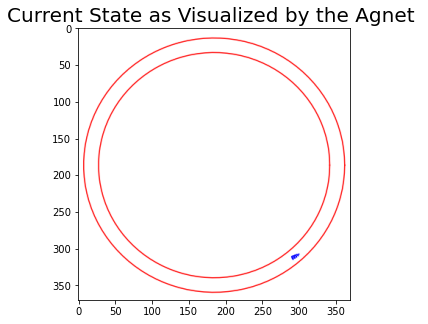

Angle Moved in Current Step:  1.095658068520765
Reward Earned in Current Step:  0.01912284077172899


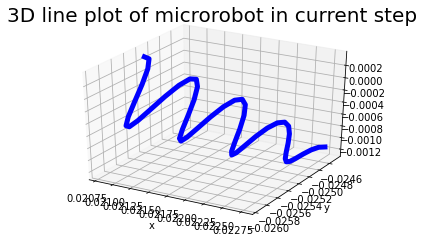

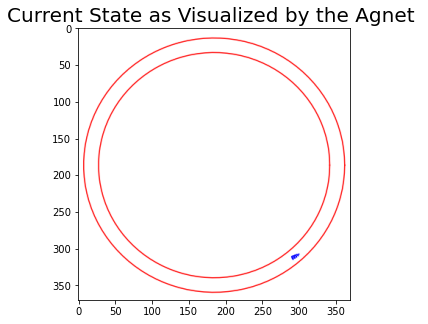

Angle Moved in Current Step:  14.968115371406283
Reward Earned in Current Step:  0.26124289604941353


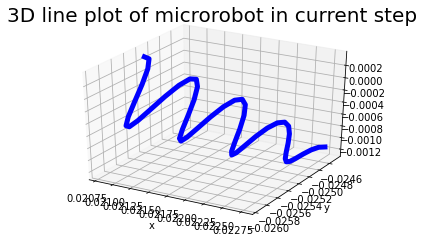

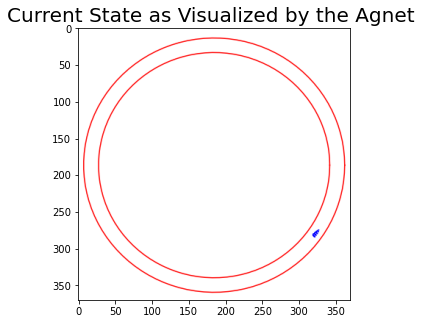

Angle Moved in Current Step:  22.491336169621846
Reward Earned in Current Step:  0.39254786933279107


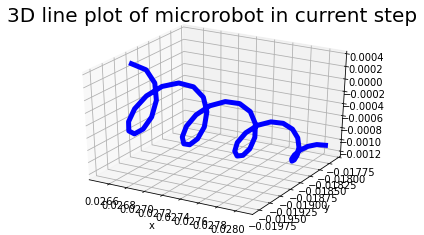

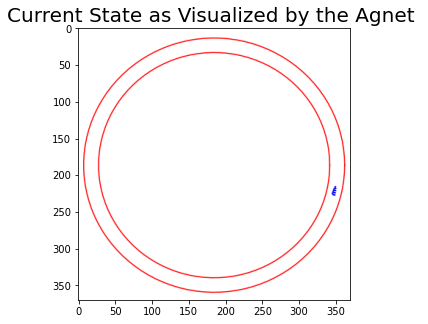

Angle Moved in Current Step:  121.49234143960823
Reward Earned in Current Step:  2.120441374078311


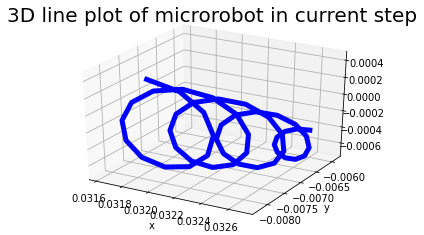

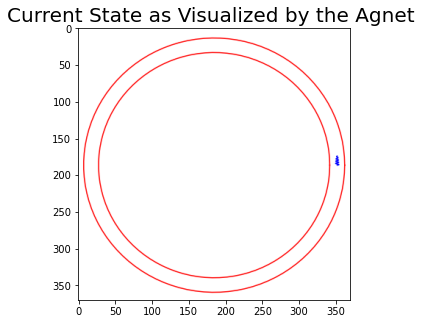

Current Episode: 0 | Reward : 2.462812805774881


'\nplt.figure(figsize=(5,5))\nplt.title("Episode reward for random agent or random exploration of actions", fontsize=20)\nplt.plot(rew, \'b\')\nplt.xlabel("Episodes/Epochs", fontsize=20)\nplt.ylabel("Reward", fontsize=20)\nplt.show()\n'

In [41]:
# variables to be tracked for understanding the working of the SAC agnet 
next_states = []
states = []
rew = []
action_plot = []
all_info = []

for i in range(1): 
  state = env.reset()
  done = False
  cnt=1
  while done == False:
    #clear_output()
    st = np.asarray(state, dtype=np.float32) 
    st = tf.expand_dims(st, axis=0)
    action , log_probs= policy_net.evaluate(st) # Obtain an action from the agnet according to learned policy
    #print(action.numpy())
    # Convert the action in a given range. 
    act = action.numpy()
    Mx = act[0][0]*100
    My = act[0][1]*100
    phix = act[0][2]*np.pi*2 
    phiy = act[0][3]*np.pi*2
    action_implement = [Mx, My, phix, phiy]
    #print(action_implement)
  
    # Implement action in the env 
    next_state, reward, done, info = env.step(action_implement)
    next_states.append(next_state)
    state = next_state 
    states.append(state)
    # See the angle and position of microrobot in after the implementation of current action. (Just for monitoring the system )
    P=info["P"] #numpy.matlib.repmat(Pr,Prot.shape[1],1)+Prot.T
    all_info.append(info)
    print("Angle Moved in Current Step: ", reward*180/np.pi)
    print("Reward Earned in Current Step: ", reward)
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(P[:,0],P[:,1],P[:,2],color='b', linewidth=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('3D line plot of microrobot in current step', fontsize=20)
    #
    
    plt.figure(figsize=(5,5))
    plt.imshow(next_state)
    plt.title("Current State as Visualized by the Agnet ", fontsize=20)
    plt.pause(1)
    
    
  rew.append(env.epi_reward)
  print(f"Current Episode: {i} | Reward : {env.epi_reward}")
    
"""
plt.figure(figsize=(5,5))
plt.title("Episode reward for random agent or random exploration of actions", fontsize=20)
plt.plot(rew, 'b')
plt.xlabel("Episodes/Epochs", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.show()
"""

In [59]:
class policy_network1(tf.keras.Model):
  def __init__(self, num_actions):
    super(policy_network1, self).__init__()
    self.in_layer_image = layers.Conv2D(64, (3, 3), activation='relu',input_shape=(370, 370, 3), name='input_layer' )
    self.pool = layers.MaxPool2D()
    self.layer_1_image = layers.Conv2D(64, (3, 3), activation='relu')
    self.pool = layers.MaxPool2D()
    self.layer_2_image = layers.Conv2D(64, (3, 3), activation='relu')
    self.flatten = layers.Flatten()
    #self.action_process = layers.Dense(4, activation='relu')
    self.fully_connected1 = layers.Dense(64, activation='relu')
    self.fully_connected2 = layers.Dense(64, activation='relu')
    self.fully_connected3 = layers.Dense(64, activation='relu')
    self.drop_out = layers.Dropout(0.3)
    
    self.mu = layers.Dense(num_actions, activation='tanh', name='mu_out')
    self.sigma = layers.Dense(num_actions, activation='softplus', name="sigma_out")

  
  def evaluate(self,state, reparameterize=True, noise=1e-4 ):
    
    mu, sigma = self.call(state)
    sigma = tf.math.exp(sigma)
    dist = tfp.distributions.Normal(mu, sigma)
    dist1 = tfp.distributions.Normal(0, 1)
    
    z    = dist1.sample()
    #print(z)
    action = tf.keras.activations.tanh(mu+sigma*z)
    #print(action) 
    log_prob = dist.log_prob(action)
    log_prob -= tf.math.log(1 - tf.math.pow(action, 2) + noise)
    log_prob = tf.math.reduce_sum(log_prob, axis=1, keepdims=True)
    """
    mean, log_std = self.call(state)
    log_std = np.exp(log_std)
    dist = tfp.distributions.Normal(0, 1)
    z = dist.sample()
    #print(mean, log_std)
    action = tf.keras.activations.tanh((mean*z)+log_std)
    log_prob = tfp.distributions.Normal(mean, log_std).log_prob(mean+ log_std*z) - tf.math.log(1 - tf.math.pow(action, 2) + 1e-2) 
    """
    return action, log_prob
  def call(self, x):
    x = self.in_layer_image(x)
    x = self.pool(x)
    x = self.layer_1_image(x)
    x = self.pool(x)
    x = self.layer_2_image(x)
    x = self.flatten(x)
    #x = self.action_process(x)
    x = self.fully_connected1(x)
    x = self.drop_out(x)
    x = self.fully_connected2(x)
    x = self.drop_out(x)
    x = self.fully_connected3(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    sigma = tf.clip_by_value(sigma, clip_value_min = -1, clip_value_max=1) # The value is approaching to zero. (0~,1) 
    return mu, sigma

  def get_action(self, state):
    action, log_prob = self.evaluate(state)
    print(action)
    action = action[0]
    Mx = action[0]*100
    My = action[1]*100
    phix = action[2]*np.pi*2
    phiy = action[3]*np.pi*2
    return [Mx.numpy(), My.numpy(), phix.numpy(), phiy.numpy()]



In [81]:
# Initializing the env and policy network for testing the environment. Further the learned weights are loaded to the neural network. 
env = mirobot_env()
policy_net1 = policy_network1(num_actions = env.action_space.shape[0])
policy_net1.build(input_shape=(None, 370, 370, 3))
#policy_net1.load_weights("/content/drive/MyDrive/Microrobot_Policy_Weights_mean_track_update.h5")

policy_net1.load_weights("/content/drive/MyDrive/Microrobot_Policy_Weights_2_60_update.h5")


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Angle Moved in Current Step:  0.06501016781643543
Reward Earned in Current Step:  0.06501016781643543


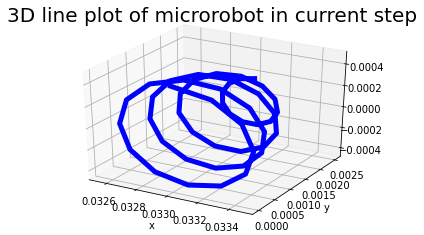

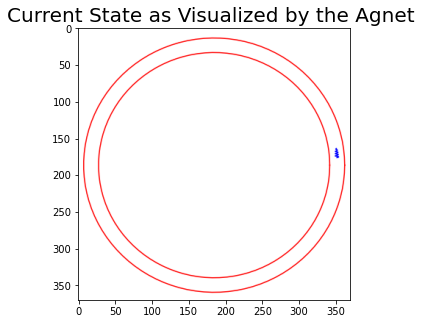

Angle Moved in Current Step:  0.7326258138229917
Reward Earned in Current Step:  0.7326258138229917


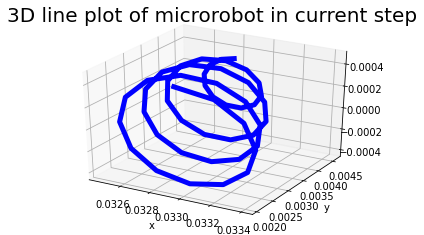

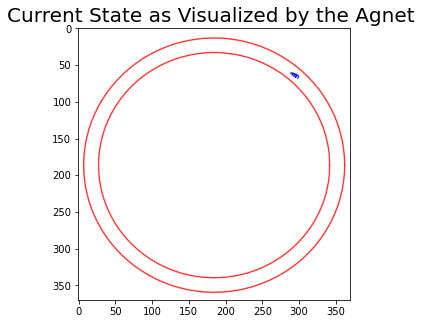

Angle Moved in Current Step:  0.7709716689388095
Reward Earned in Current Step:  0.7709716689388095


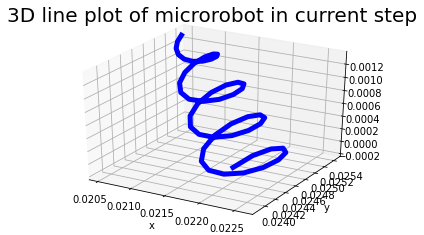

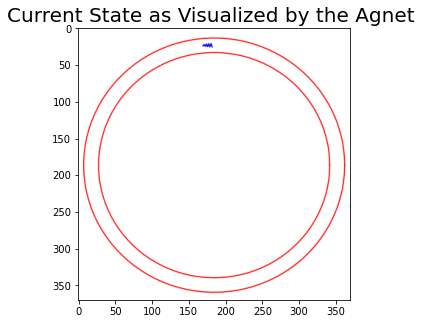

Angle Moved in Current Step:  -0.6404016258824683
Reward Earned in Current Step:  -0.6404016258824683


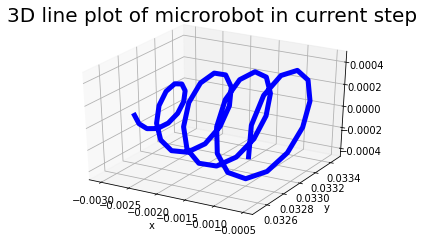

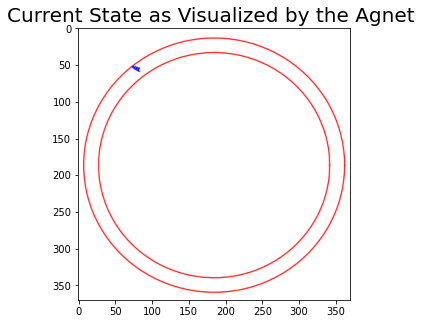

Angle Moved in Current Step:  0.8501105627225769
Reward Earned in Current Step:  0.8501105627225769


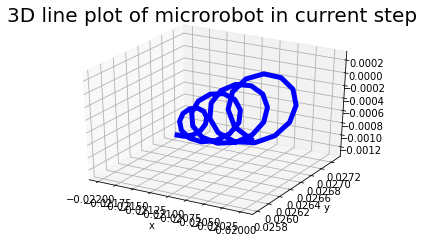

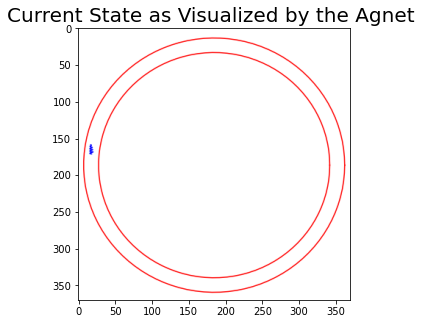

Angle Moved in Current Step:  0.927541511686556
Reward Earned in Current Step:  0.927541511686556


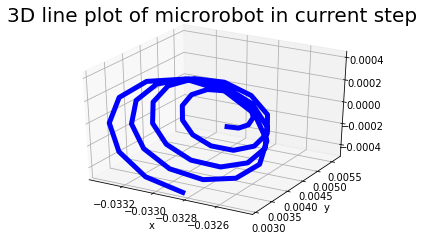

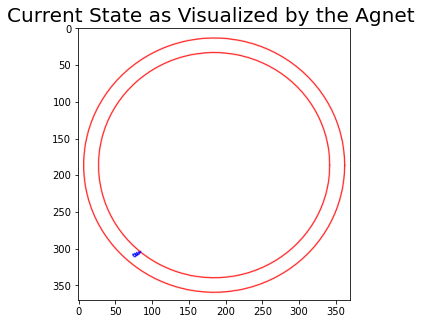

Angle Moved in Current Step:  0.12686748352060917
Reward Earned in Current Step:  0.12686748352060917


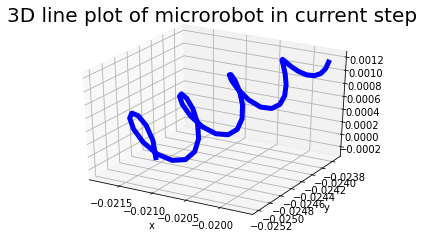

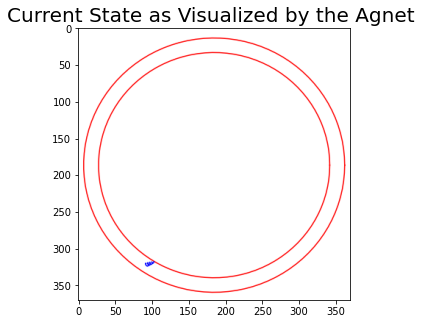

Angle Moved in Current Step:  -1.0989563934348752
Reward Earned in Current Step:  -1.0989563934348752


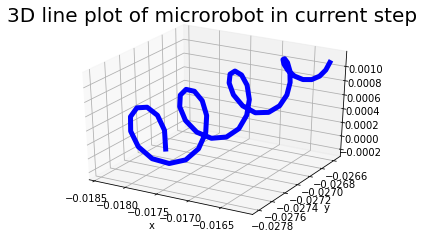

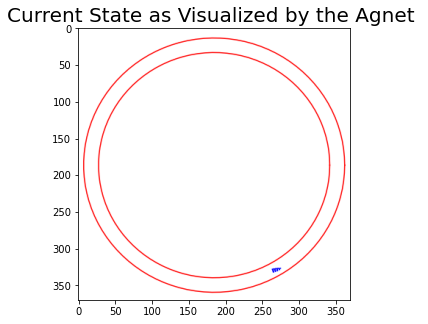

Angle Moved in Current Step:  -0.14353716795705296
Reward Earned in Current Step:  -0.14353716795705296


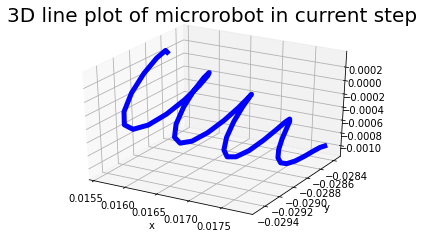

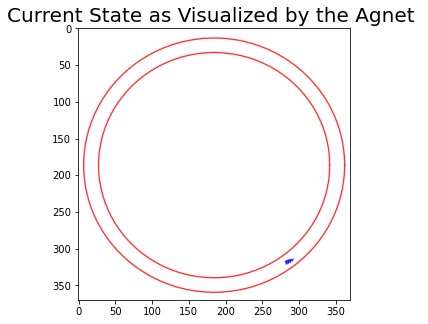

Angle Moved in Current Step:  0.8535319665416345
Reward Earned in Current Step:  0.8535319665416345


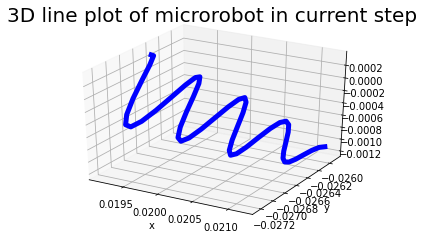

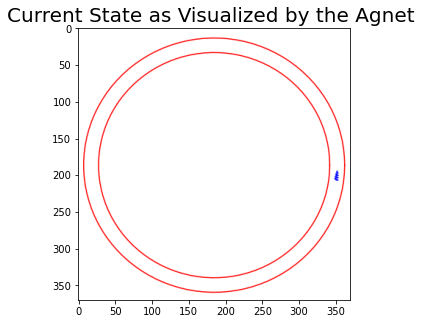

Angle Moved in Current Step:  -0.6597677964764301
Reward Earned in Current Step:  -0.6597677964764301


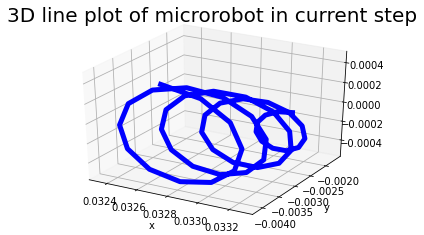

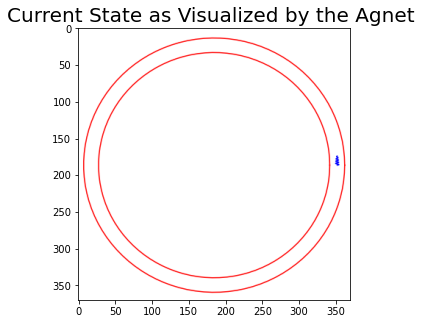

In [82]:
# variables to be tracked for understanding the working of the SAC agnet 
next_states = []
states = []
rew1 = []
action_plot = []
all_info = []

for i in range(1): 
  done = False
  cnt=1
  state = env.reset()
  while done == False:
    #clear_output()
    st = np.asarray(state, dtype=np.float32) 
    st = tf.expand_dims(st, axis=0)
    action , log_probs= policy_net1.evaluate(st) # Obtain an action from the agnet according to learned policy
    #print(action.numpy())
    # Convert the action in a given range. 
    act = action.numpy()
    Mx = act[0][0]*100
    My = act[0][1]*100
    phix = act[0][2]*np.pi*2 
    phiy = act[0][3]*np.pi*2
    action_implement = [Mx, My, phix, phiy]
    #print(action_implement)
  
    # Implement action in the env 
    next_state, reward, done, info = env.step(action_implement)
    

    next_states.append(next_state)
    state = next_state 
    states.append(state)
    action_plot.append(action_implement)
    # See the angle and position of microrobot in after the implementation of current action. (Just for monitoring the system )
    P=info["P"] #numpy.matlib.repmat(Pr,Prot.shape[1],1)+Prot.T
    all_info.append(info)
    print("Angle Moved in Current Step: ", reward*180/np.pi)
    print("Reward Earned in Current Step: ", reward)
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(P[:,0],P[:,1],P[:,2],color='b', linewidth=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('3D line plot of microrobot in current step', fontsize=20)
    #
    
    plt.figure(figsize=(5,5))
    plt.imshow(next_state)
    plt.title("Current State as Visualized by the Agnet ", fontsize=20)
    plt.pause(1)
    
    
    rew1.append(reward)
    



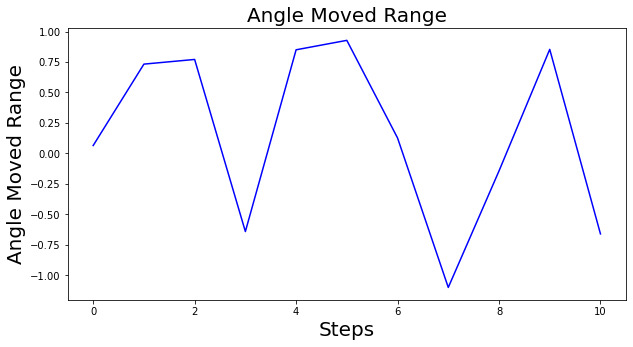

In [83]:
plt.figure(figsize=(10,5))
plt.title("Angle Moved Range", fontsize=20)
plt.plot(rew1, 'b')
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Angle Moved Range", fontsize=20)
plt.show()


Loading the data from the training section for checking the difference between various training steps. 

In [ ]:
actions_collections =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{100}_actions_collections.npy", allow_pickle=True)
#info_collection =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{10}_info_collections.npy", allow_pickle=True)
#reward_track =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{10}_reward_track.npy" , allow_pickle=True)
#loss=np.load(f"/content/drive/MyDrive/Microrobot_Weights_{10}_loss.npy", allow_pickle=True)
#mean_reward  =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{10}_mean_reward.npy", allow_pickle=True)


In [ ]:
# Plot the system behaviour
ix, iy, iz = [], [], []
fx, fy, fz = [], [], []
mx, my, mz = [], [], []
tx, ty, tz = [], [], []
th_curr, th_prev, time_now = [],[],[]
for i in range(len(info_collection)):
    dat = info_collection[i]['res_currents']
    f = info_collection[i]['force']
    t = info_collection[i]['torque']
    m = info_collection[i]['momentum']
    th_curr.append(info_collection[i]['th_current'])
    th_prev.append(info_collection[i]['th_previous'])
    time_now.append(info_collection[i]['time_elasped'])
    ix.append(dat[0])
    iy.append(dat[1])
    iz.append(dat[2])
    fx.append(f[0])
    fy.append(f[1])
    fz.append(f[2])
    tx.append(t[0])
    ty.append(t[1])
    tz.append(t[2])
    mx.append(f[0])
    my.append(f[1])
    mz.append(f[2])


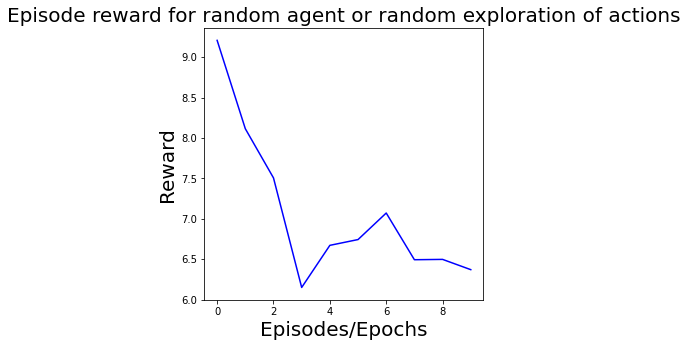

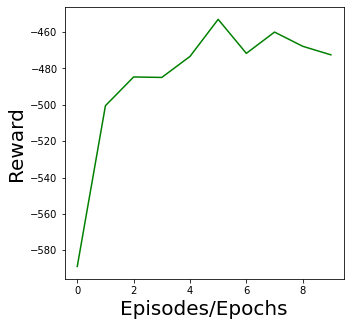

In [29]:
#actions_collections =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{90}_actions_collections.npy", allow_pickle=True)
#info_collection =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{90}_info_collections.npy", allow_pickle=True)
reward_track1 =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{100}_reward_track.npy" , allow_pickle=True)
reward_track2 =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{400}_reward_track.npy" , allow_pickle=True)

#loss=np.load(f"/content/drive/MyDrive/Microrobot_Weights_{90}_loss.npy", allow_pickle=True)
mean_reward1  =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{100}_mean_reward.npy", allow_pickle=True)
mean_reward2  =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{400}_mean_reward.npy", allow_pickle=True)

plt.figure(figsize=(5,5))
plt.title("Episode reward for random agent or random exploration of actions", fontsize=20)
plt.plot(mean_reward1, 'b')
plt.xlabel("Episodes/Epochs", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mean_reward2, 'g')
plt.xlabel("Episodes/Epochs", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.show()

In [19]:
info_collection =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{100}_info_collections.npy", allow_pickle=True)
# Plot the system behaviour
ix, iy, iz = [], [], []
fx, fy, fz = [], [], []
mx, my, mz = [], [], []
tx, ty, tz = [], [], []
th_curr, th_prev, time_now = [],[],[]
for i in range(len(info_collection)):
    dat = info_collection[i]['res_currents']
    f = info_collection[i]['force']
    t = info_collection[i]['torque']
    m = info_collection[i]['momentum']
    th_curr.append(info_collection[i]['th_current'])
    th_prev.append(info_collection[i]['th_previous'])
    time_now.append(info_collection[i]['time_elasped'])
    ix.append(dat[0])
    iy.append(dat[1])
    iz.append(dat[2])
    fx.append(f[0])
    fy.append(f[1])
    fz.append(f[2])
    tx.append(t[0])
    ty.append(t[1])
    tz.append(t[2])
    mx.append(f[0])
    my.append(f[1])
    mz.append(f[2])
info_collection =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{400}_info_collections.npy", allow_pickle=True)
# Plot the system behaviour
ix1, iy1, iz1 = [], [], []
fx1, fy1, fz1 = [], [], []
mx1, my1, mz1 = [], [], []
tx1, ty1, tz1 = [], [], []
th_curr1, th_prev1, time_now1 = [],[],[]
for i in range(len(info_collection)):
    dat = info_collection[i]['res_currents']
    f = info_collection[i]['force']
    t = info_collection[i]['torque']
    m = info_collection[i]['momentum']
    th_curr1.append(info_collection[i]['th_current'])
    th_prev1.append(info_collection[i]['th_previous'])
    time_now1.append(info_collection[i]['time_elasped'])
    ix1.append(dat[0])
    iy1.append(dat[1])
    iz1.append(dat[2])
    fx1.append(f[0])
    fy1.append(f[1])
    fz1.append(f[2])
    tx1.append(t[0])
    ty1.append(t[1])
    tz1.append(t[2])
    mx1.append(f[0])
    my1.append(f[1])
    mz1.append(f[2])

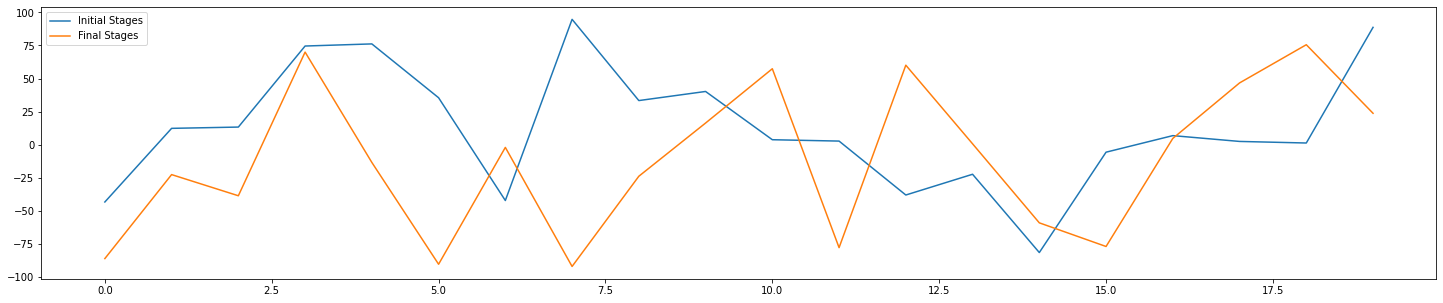

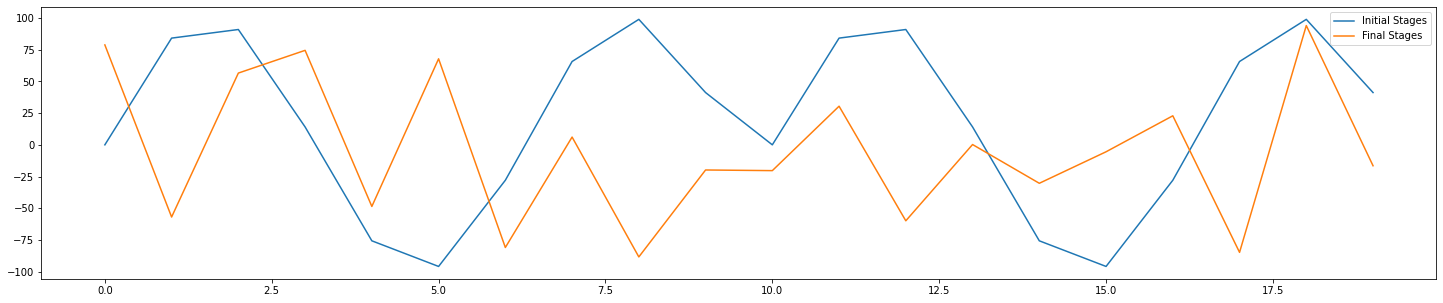

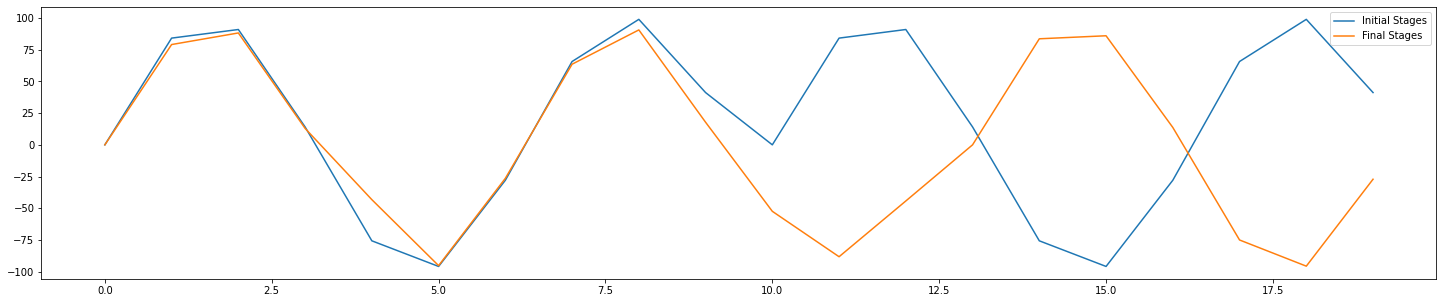

In [20]:
plt.figure(figsize=(25,5))
plt.plot(ix[0:20])
plt.plot(ix1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(iy[0:20])
plt.plot(iy1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(iz[0:20])
plt.plot(iz1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()

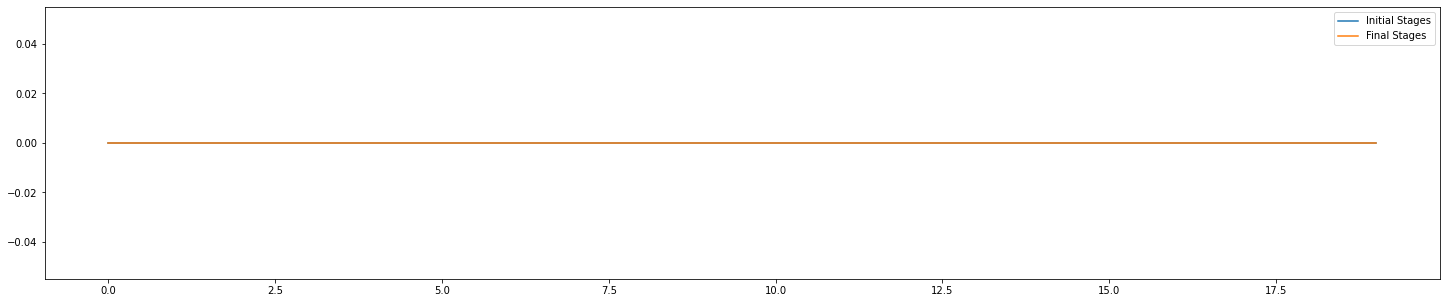

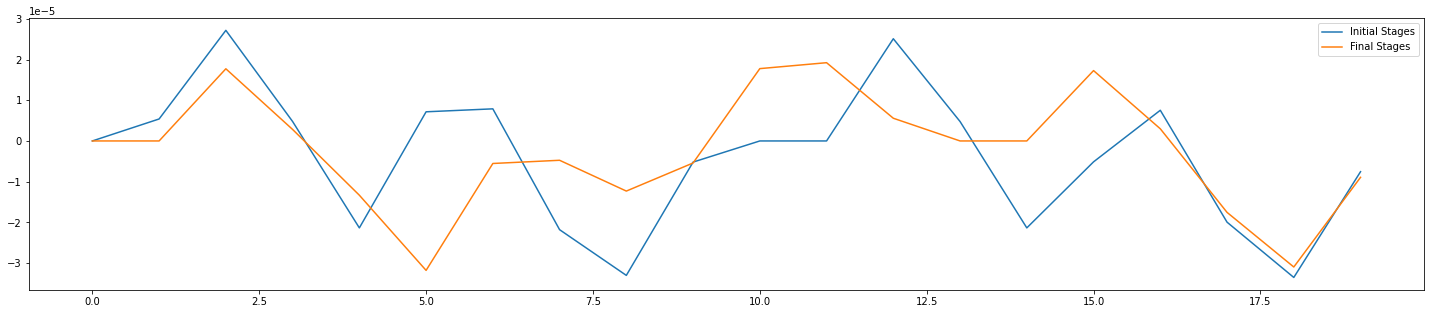

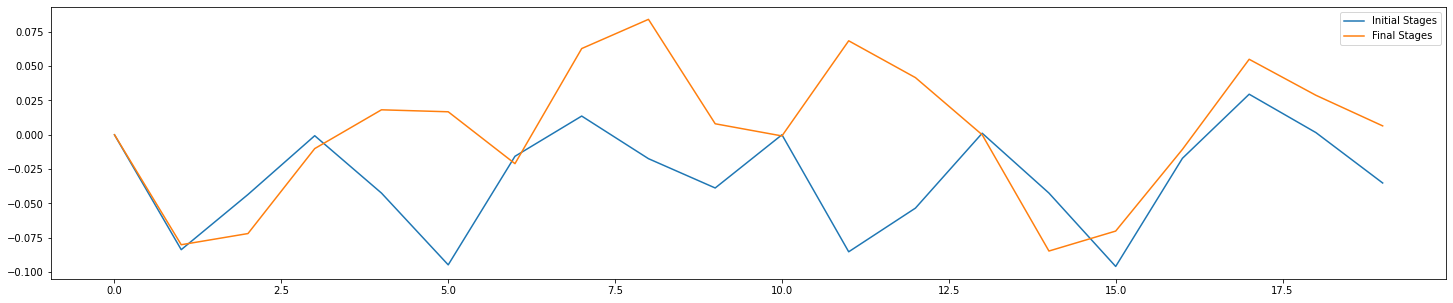

In [21]:
plt.figure(figsize=(25,5))
plt.plot(fx[0:20])
plt.plot(fx1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(fy[0:20])
plt.plot(fy1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(fz[0:20])
plt.plot(fz1[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()

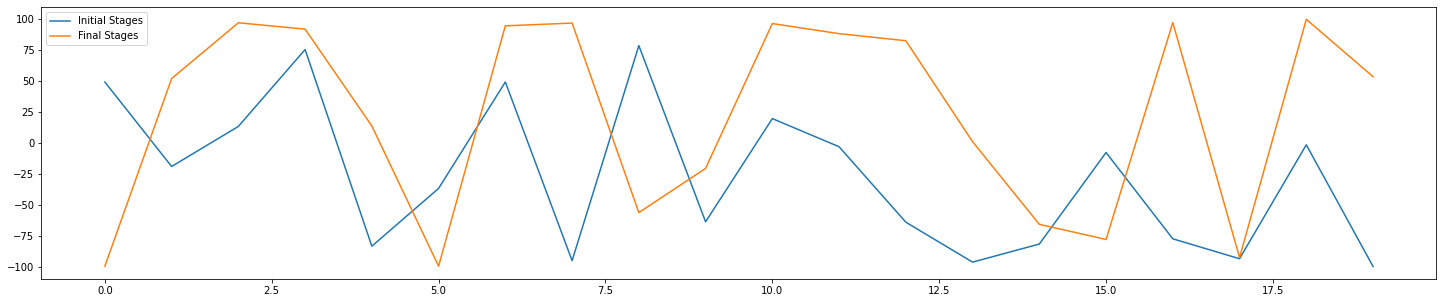

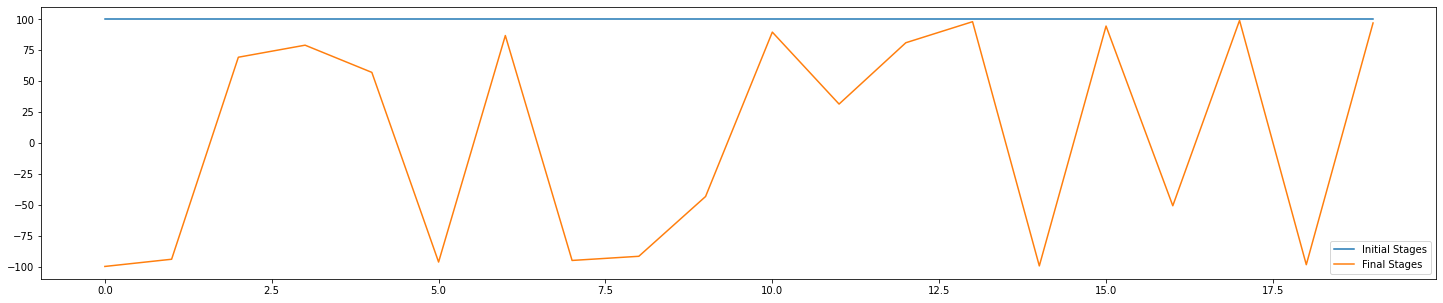

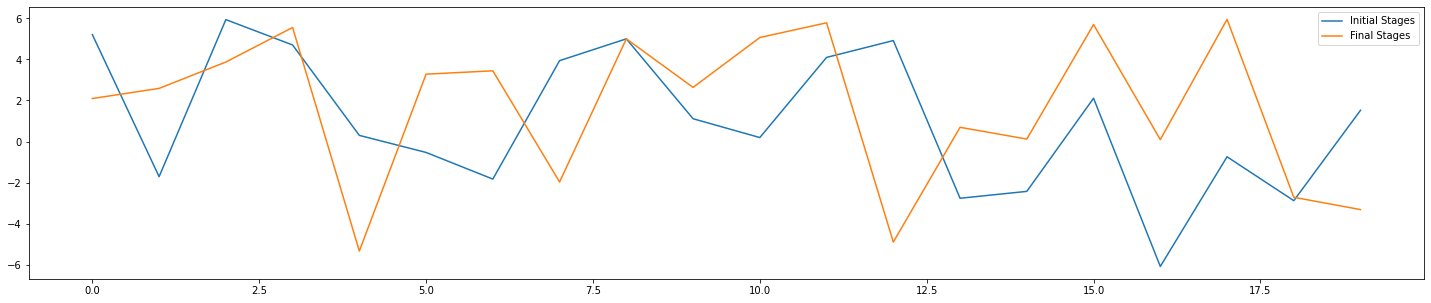

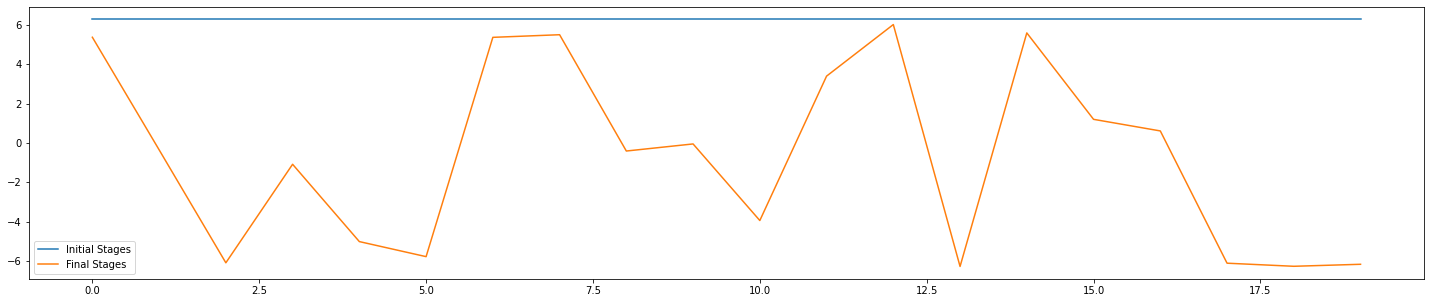

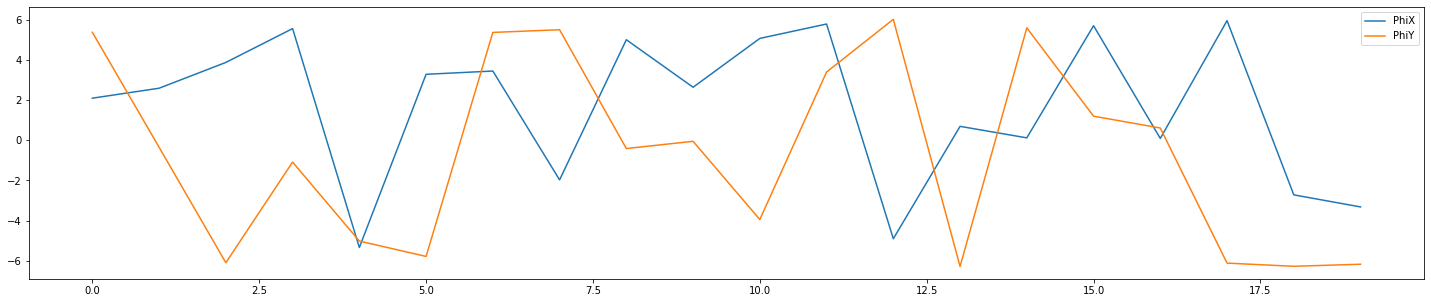

In [22]:
actions_collections =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{100}_actions_collections.npy", allow_pickle=True)
mx_ac1 = []
my_ac1 = []
phix_ac1 = []
phiy_ac1 = []
for act in actions_collections:
  mx_ac1.append(act[0])
  my_ac1.append(act[1])
  phix_ac1.append(act[2])
  phiy_ac1.append(act[3])

actions_collections =np.load(f"/content/drive/MyDrive/Microrobot_Weights_{400}_actions_collections.npy", allow_pickle=True) #f"/content/drive/MyDrive/Microrobot_Weights_{90}_actions_collections.npy"
mx_ac2 = []
my_ac2 = []
phix_ac2 = []
phiy_ac2 = []
for act in actions_collections:
  mx_ac2.append(act[0])
  my_ac2.append(act[1])
  phix_ac2.append(act[2])
  phiy_ac2.append(act[3])
plt.figure(figsize=(25,5))
plt.plot(mx_ac1[0:20])
plt.plot(mx_ac2[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(my_ac1[0:20])
plt.plot(my_ac2[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()
plt.figure(figsize=(25,5))
plt.plot(phix_ac1[0:20])
plt.plot(phix_ac2[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()

plt.figure(figsize=(25,5))
plt.plot(phiy_ac1[0:20])
plt.plot(phiy_ac2[0:20])
plt.legend(['Initial Stages', 'Final Stages'])
plt.show()

plt.figure(figsize=(25,5))
plt.plot(phix_ac2[0:20])
plt.plot(phiy_ac2[0:20])
plt.legend(['PhiX', 'PhiY'])
plt.show()

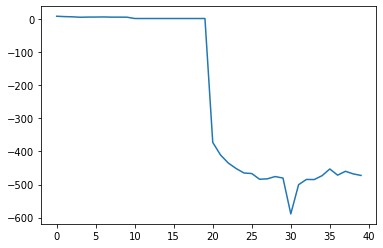

In [23]:
mean_reward = []
for i in range(401):
  if (i%100 == 0) and (i != 0): 
    data = np.load(f"/content/drive/MyDrive/Microrobot_Weights_{i}_mean_reward.npy", allow_pickle=True)
    for d in data:
      mean_reward.append(d)
    #mean_reward.append())


plt.plot(mean_reward)

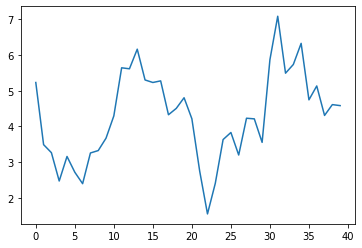

In [24]:
mean_reward = []
for i in range(401):
  if (i%100 == 0) and (i != 0): 
    data = np.load(f"/content/drive/MyDrive/Microrobot_Weights_2_{i}_mean_reward.npy", allow_pickle=True)
    for d in data:
      mean_reward.append(d)
    #mean_reward.append())


plt.plot(mean_reward)

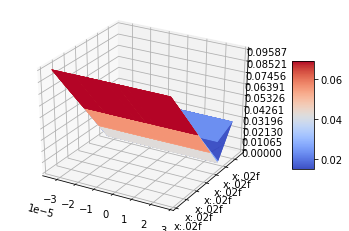

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import matplotlib.ticker as tick
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.asarray(fy[0:20])
Y = np.asarray(fz[0:20])
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

# Customize the z axis.
#ax.set_zlim(-.5, .5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('x:.02f')
#import matplotlib.ticker as tick

y_fmt = tick.FormatStrFormatter('x:.02f')
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

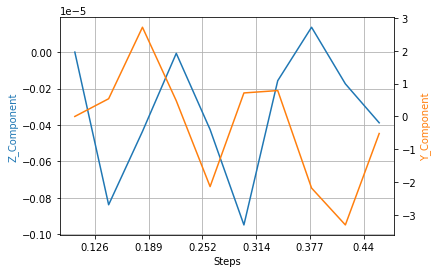

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Steps")
host.set_ylabel("Z_Component")
par.set_ylabel("Y_Component")

p1, = host.plot(time_now[0:10], mz[0:10], label="Z_Component")
p2, = par.plot(time_now[0:10],my[0:10], label="Y_Component")
#par.set_xticks(ticks= [_ for _ in range(len(time_now[0:10]))])
par.set_xticklabels([str(round(_, 3)) for _ in (time_now[0:10])])

#host.legend(labelcolor="linecolor")

host.yaxis.get_label().set_color(p1.get_color())
par.yaxis.get_label().set_color(p2.get_color())
plt.grid()
plt.show()